In [175]:
from random import randrange
import matplotlib.pyplot as plt
import numpy as np
import cv2
figsize = (10, 10)


In [176]:
#load left and right images
rgb_l = cv2.cvtColor(cv2.imread("dt-left.jpeg"), cv2.COLOR_BGR2RGB)
gray_l = cv2.cvtColor(rgb_l, cv2.COLOR_RGB2GRAY)
rgb_r = cv2.cvtColor(cv2.imread("dt-right.jpeg"), cv2.COLOR_BGR2RGB)
gray_r = cv2.cvtColor(rgb_r, cv2.COLOR_RGB2GRAY)

## SIFT feature detection and description


3.a) Extract Matches

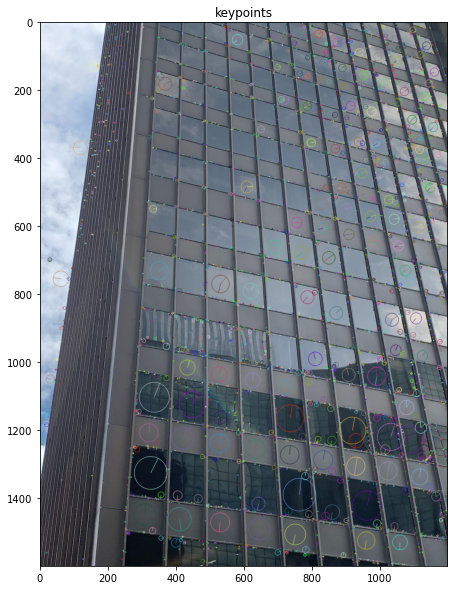

In [177]:
# use orb if sift is not installed
feature_extractor = cv2.SIFT_create()

# find the keypoints and descriptors with chosen feature_extractor
kp_l, desc_l = feature_extractor.detectAndCompute(gray_l, None)
kp_r, desc_r = feature_extractor.detectAndCompute(gray_r, None)

test = cv2.drawKeypoints(rgb_l, kp_l, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=figsize)
plt.imshow(test)
plt.title("keypoints")
plt.show()



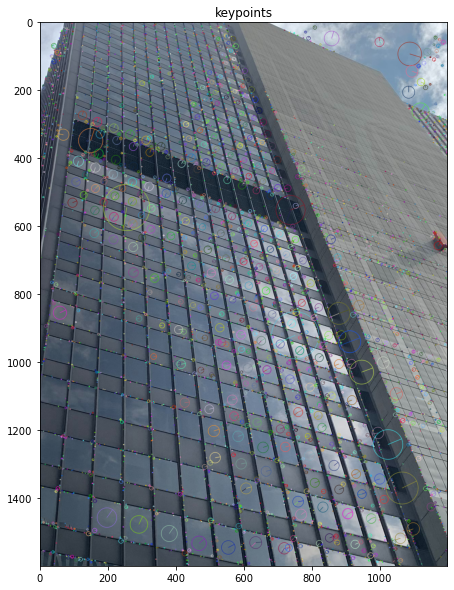

In [178]:
test = cv2.drawKeypoints(rgb_r, kp_r, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=figsize)
plt.imshow(test)
plt.title("keypoints")
plt.show()

## obtain matches between keypoints extracted from left, right images using their descriptors


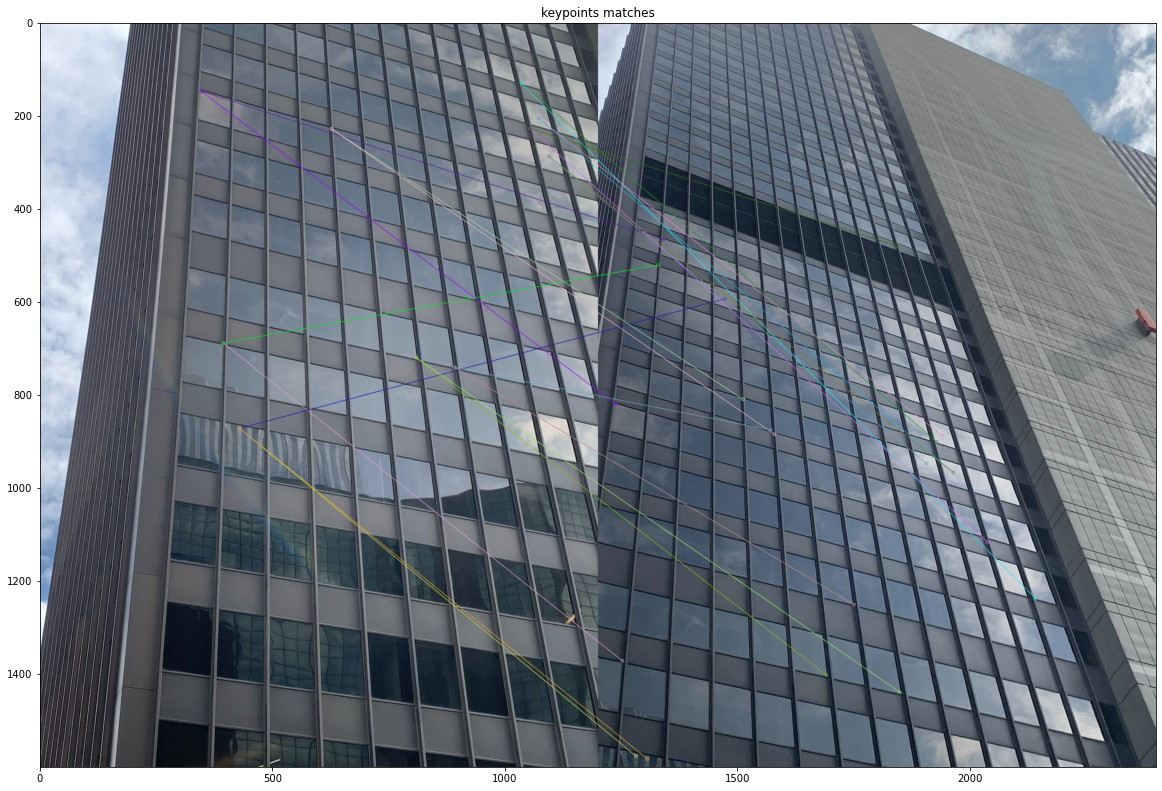

In [179]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc_l, desc_r, k=2)

# Apply ratio test
good_and_second_good_match_list = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good_and_second_good_match_list.append([m,n])
good_match_arr = np.asarray(good_and_second_good_match_list)[:,0]

# show only 30 matches
im_matches = cv2.drawMatchesKnn(rgb_l, kp_l, rgb_r, kp_r,
                                good_and_second_good_match_list[0:30], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20, 20))
plt.imshow(im_matches)
plt.title("keypoints matches")
plt.show()



## 3.b) find homography between images


In [180]:
# extract the good/top matched keypoints in left image from good_match_arr using queryidx
good_kp_l = np.array([kp_l[m.queryIdx].pt for m in good_match_arr])

# extract the good/top matched keypoints in right image from good_match_arr using trainidx
good_kp_r = np.array([kp_r[m.trainIdx].pt for m in good_match_arr])

In [181]:
# calculate homography using the matches.

#src = right
#dest - left
H, mask = cv2.findHomography(good_kp_r, good_kp_l, cv2.RANSAC,5.0)

print(H)


[[ 1.10666866e+00  1.26502509e-01  2.44605381e+02]
 [-3.30209028e-02  1.21653688e+00 -8.31222098e+02]
 [-5.78227710e-05  1.57705530e-04  1.00000000e+00]]


## 3.c) overlay images


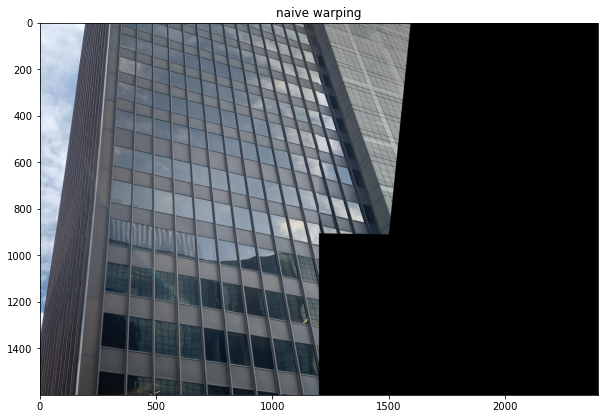

In [182]:
# step 1: warp the right image using H or alternatively left image using inverse(H) with output width as sum of widths of the images
rgb_r_warped = cv2.warpPerspective(rgb_r, H, ( 1200+1200, rgb_l.shape[0]))


# step 2: place the left image in the left half of the output warp in the above output after step 1
rgb_r_warped[0:rgb_l.shape[0], 0:rgb_l.shape[1]] = rgb_l

plt.figure(figsize=figsize)
plt.imshow(rgb_r_warped)
plt.title("naive warping")
plt.show()


In [183]:
def full_warpTwoImages(img1, img2, H):
    '''warp img2 to img1 with homograph H
    '''
    #img1 = left image
    #img2 = right image
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # corners of the images
    pts_l = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts_r = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)


    # find the corners of img2 after transforming them with H
    #pts_r_ = pts_r
    pts_r_ = cv2.perspectiveTransform(pts_r, H)
    #print(pts_r_)

    # step 0: find the translation required from the 8 corners i.e., pts1 and pts2_
    pts_r_1 = pts_r_[0]
    pts_r_2 = pts_r_[1]
    pts_r_3 = pts_r_[2]
    pts_r_4 = pts_r_[3]

    #print(pts_r_1, pts_r_2, pts_r_3, pts_r_4)
    
    pts_l_1 = pts_l[0]
    pts_l_2 = pts_l[1]
    pts_l_3 = pts_l[2]
    pts_l_4 = pts_l[3]

    #print(pts_l_1, pts_l_2, pts_l_3, pts_l_4)
    
    allPts = np.float32([pts_r_1, pts_r_2, pts_r_3, pts_r_4, pts_l_1, pts_l_2, pts_l_3, pts_l_4]).reshape(-1, 1, 2)

    extLeft = tuple(allPts[allPts[:, :, 0].argmin()][0])
    extRight = tuple(allPts[allPts[:, :, 0].argmax()][0])
    extTop = tuple(allPts[allPts[:, :, 1].argmin()][0])
    extBot = tuple(allPts[allPts[:, :, 1].argmax()][0])

    print("extents points", extLeft, extRight, extTop, extBot)

    topmost = int(extTop[1])
    leftmost = int(extLeft[0])
    botmost = int(extBot[1])
    rightmost = int(extRight[0])

    print("top: ", topmost, "bottom: ", botmost, "left: ", leftmost, "right: ", rightmost)

    Ht = H

    newH = int(np.abs(topmost)) + int(botmost) + 1
    newW = int(np.abs(leftmost)) + int(rightmost) + 1

    print(newH, newW)

    Ht[0,2] += topmost #translate x center to topmost
    Ht[1,2] += leftmost #translate y center to leftmost

    # step 1: warp img2 using composition of H and translation found in step 0 and output size as the total size
    result = cv2.warpPerspective(img2, Ht, (newH, newW))
    
    # step 2: place img1 in result using the translations in step 0
    result[0:h1, 0:w1] = img1

    return result

result = full_warpTwoImages(rgb_l, rgb_r, H)

plt.figure(figsize=figsize)
plt.imshow(result)
plt.title("full warp")
plt.show()



extents points (0.0, 0.0) (1689.8628, -935.7783) (1689.8628, -935.7783) (0.0, 1600.0)
top:  -935 bottom:  1600 left:  0 right:  1689
2536 1690


KeyboardInterrupt: 

# Parts d) and e)   

### Extract and Match keypoints (3.a)

In [ ]:
def loadImgSet(left, right):
    rgb_l = cv2.cvtColor(cv2.imread(left), cv2.COLOR_BGR2RGB)
    gray_l = cv2.cvtColor(rgb_l, cv2.COLOR_RGB2GRAY)
    rgb_r = cv2.cvtColor(cv2.imread(right), cv2.COLOR_BGR2RGB)
    gray_r = cv2.cvtColor(rgb_r, cv2.COLOR_RGB2GRAY)

    return rgb_l, gray_l, rgb_r, rgb_l

In [ ]:
def createFE(extractorID):
    if(extractorID == 0):
        feature_extractor = cv2.SIFT_create()
    else:
        feature_extractor = cv2.SIFT_create()

    return feature_extractor

In [ ]:
def plotFig(img, title, figsize):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.title(title)
    plt.show()

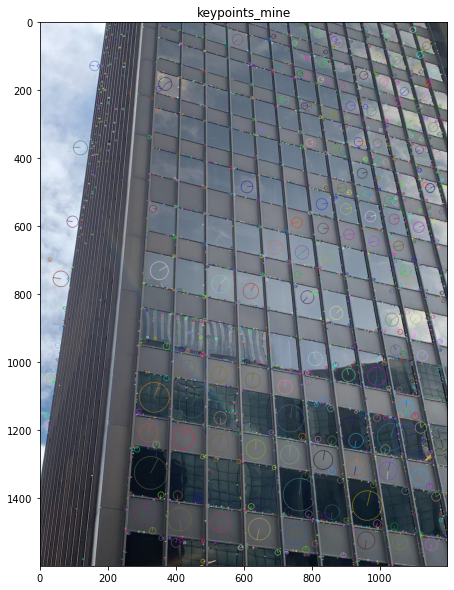

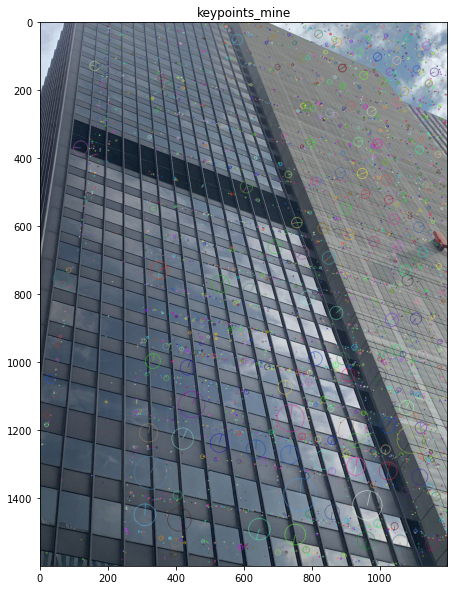

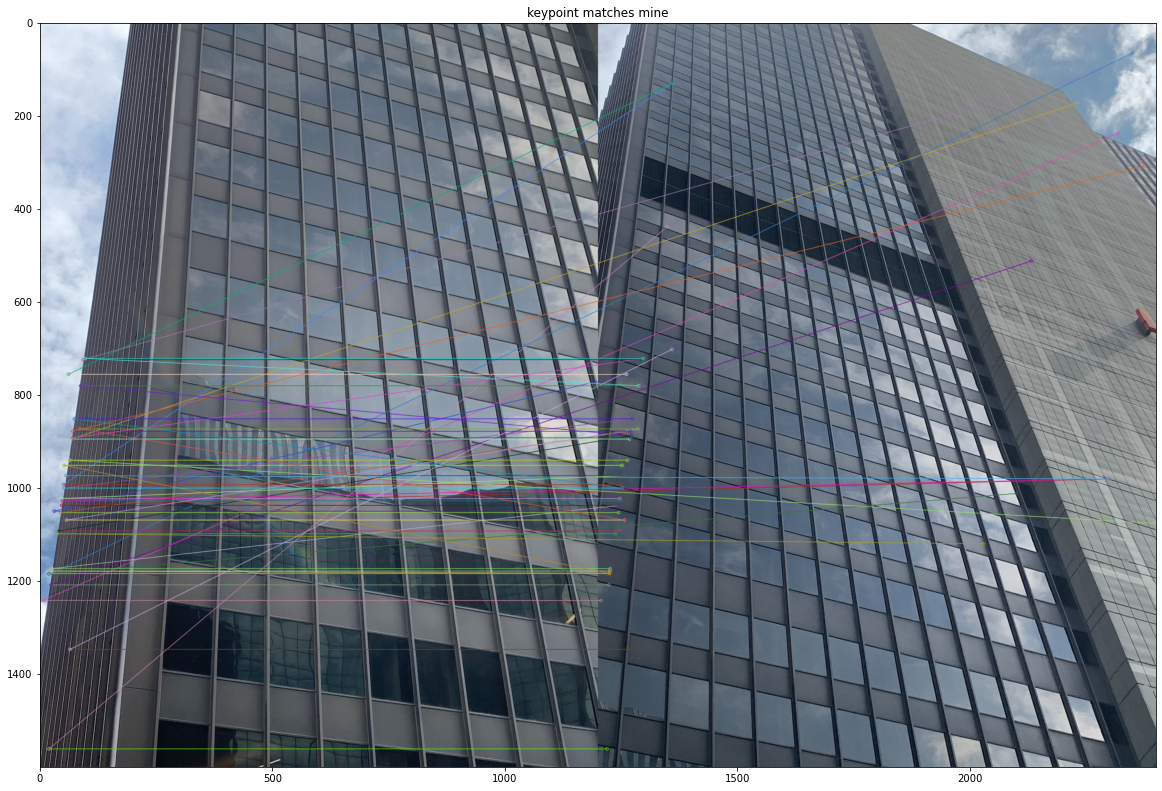

In [ ]:
rgb_l, gray_l, rgb_r, gray_r = loadImgSet("dt-left.jpeg", "dt-right.jpeg")

# IDs:
# 0 = SIFT
# 1 = TBD
#feature_extractor = createFE(0)

feature_extractor = cv2.SIFT_create()

# find the keypoints and descriptors with chosen feature_extractor
kp_l, desc_l = feature_extractor.detectAndCompute(gray_l, None)
kp_r, desc_r = feature_extractor.detectAndCompute(gray_r, None)

test = cv2.drawKeypoints(rgb_l, kp_l, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plotFig(test, "keypoints_mine", (10,10))

test = cv2.drawKeypoints(rgb_r, kp_r, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plotFig(test, "keypoints_mine", (10,10))

bf = cv2.BFMatcher()
matches = bf.knnMatch(desc_l, desc_r, k=2)

# Apply ratio test
good_and_second_good_match_list = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good_and_second_good_match_list.append([m,n])
good_match_arr = np.asarray(good_and_second_good_match_list)[:,0]

# show only 30 matches
im_matches = cv2.drawMatchesKnn(rgb_l, kp_l, rgb_r, kp_r,
                                good_and_second_good_match_list[0:30], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plotFig(im_matches, "keypoint matches mine", (20,20))
